In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data

Okay, just try verbatim what they're doing and see if it helps

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


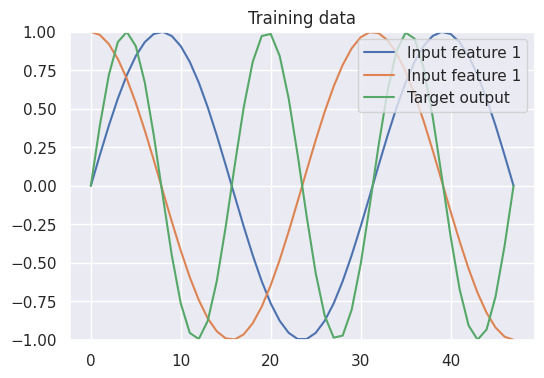

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)

data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [3]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [4]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


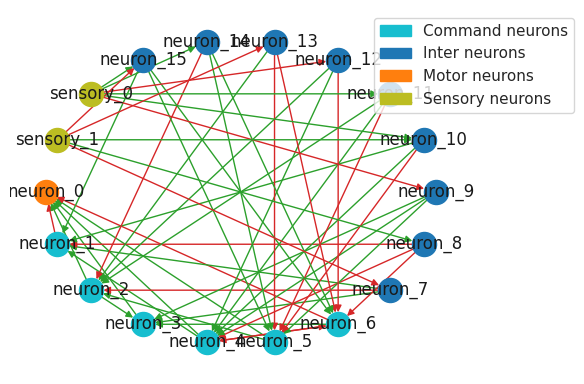

In [5]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()# Let's visualize how LTC initialy performs before the training
sns.set()

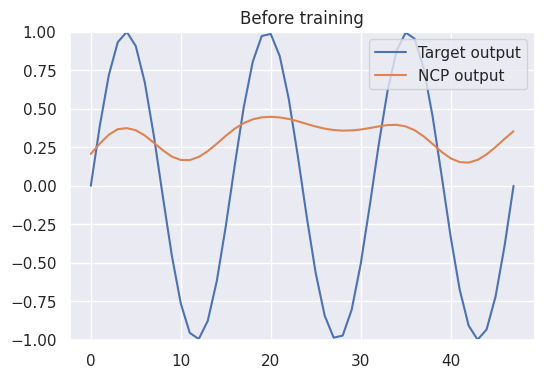

In [6]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [7]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.0 K  | train
---------------------------------------
848       Trainable params
196       Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/tristongrayston/.local/lib/python3.10/s

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


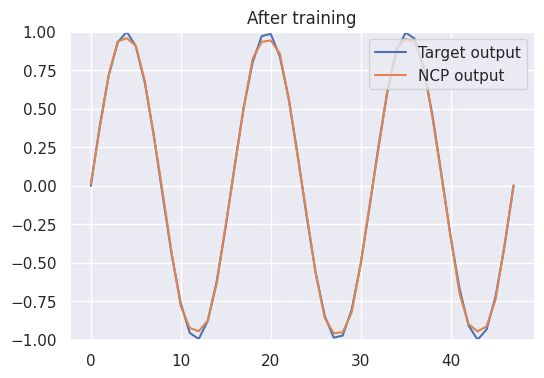

In [8]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# Test 2: Lotka–Volterra Predator–Prey Model

In [9]:
a = 1.1
b = 0.4 
g = 0.4
d = 0.1

y0 = [10, 1]
time = np.linspace(0, 50, 100)
params = (a, b, d, g)

In [10]:
def sim(variables, time, params):
    x = variables[0] # prey pop level
    y = variables[1] # pred pop level

    a, b, d, g = params
    
    dxdt = a*x - b*x*y
    dydt = d*x*y - g*y

    return [dxdt, dydt]

In [11]:
from scipy.integrate import odeint
y = odeint(sim, y0, time, args=(params,))
y = [y[:, 0] + (0.5**0.5)*np.random.normal(0, 0.5, (100,)), y[:, 1] + (0.5**0.5)*np.random.normal(0, 0.5, (100,))] 

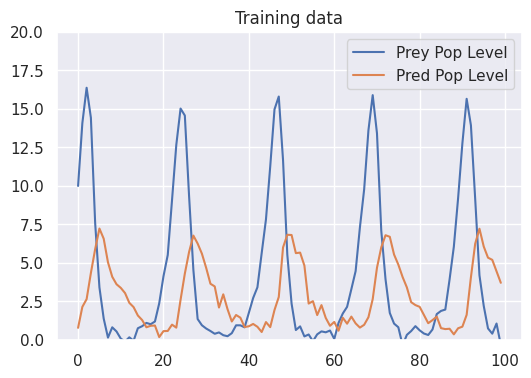

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(y[0], label="Prey Pop Level")
plt.plot(y[1], label="Pred Pop Level")
#plt.plot(y[:, 1] + y[:, 0], label="Total Population")
plt.ylim((0, 20))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [14]:
# Make batches

def batchify(data_x, data_y, input_timesteps=1):
    inputs = []
    outputs = []
    for i in range(len(data_x) - 1):
        inputs.append(torch.tensor([data_x[i], data_y[i]], dtype=torch.float32))
        outputs.append(torch.tensor([data_x[i+1], data_y[i+1]], dtype=torch.float32))

    inputs = torch.stack(inputs)
    outputs = torch.stack(outputs)
    return inputs, outputs

data_x, data_y = batchify(y[0], y[1])
data_y.shape

torch.Size([99, 2])

In [15]:
print(data_x.shape)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

torch.Size([99, 2])


In [21]:
out_features = 2
in_features = 2

wiring = AutoNCP(32, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


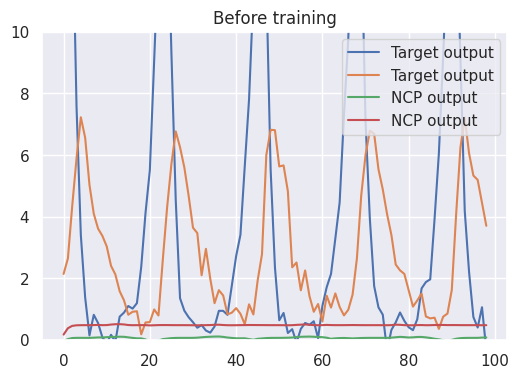

In [22]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y, label="Target output")
plt.plot(prediction, label="NCP output")
plt.ylim((0, 10))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [23]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 5.5 K  | train
---------------------------------------
4.5 K     Trainable params
1.1 K     Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


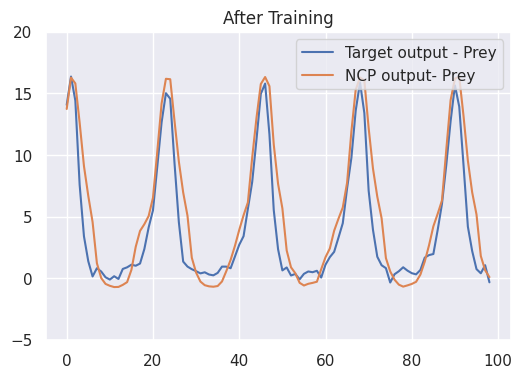

In [24]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output - Prey")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 0], label="NCP output- Prey")
plt.ylim((-5, 20))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

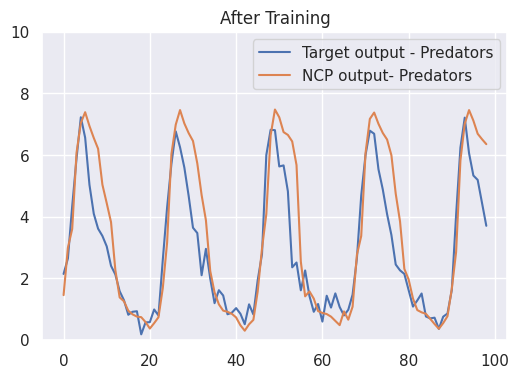

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 1], label="Target output - Predators")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 1], label="NCP output- Predators")
plt.ylim((-0, 10))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

:(

In [36]:
# Now for CFC:
out_features = 2
in_features = 2

wiring = AutoNCP(32, out_features)  # 16 units, 1 motor neuron

cfc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(cfc_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 3.9 K  | train
---------------------------------------
3.1 K     Trainable params
748       Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=400` reached.


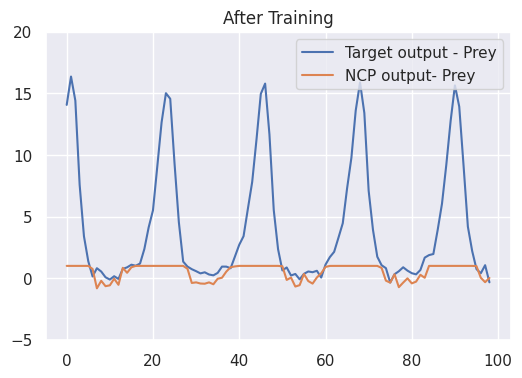

In [40]:
sns.set()
with torch.no_grad():
    prediction = cfc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output - Prey")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 0], label="NCP output- Prey")
plt.ylim((-5, 20))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

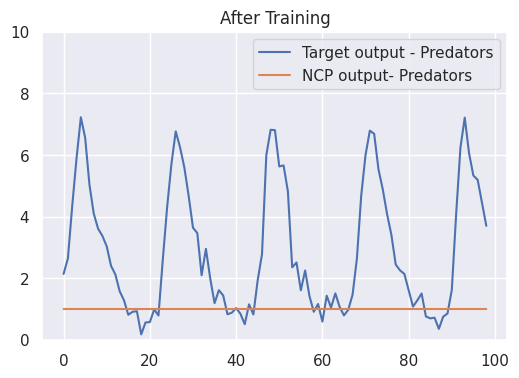

In [41]:
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 1], label="Target output - Predators")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 1], label="NCP output- Predators")
plt.ylim((-0, 10))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()